In [1]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch.utils.data as pydata
from torchsummary import summary
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random
from matplotlib import cm
import spectral as spy
from sklearn import metrics
from sklearn import preprocessing
import time
from torch.autograd import Variable
from H_datapy import *

#import CCnet2BModel1 as CC2B
import CCnetConcat2B1 as CCCon2B

import torch.nn.functional as F
from autis import *
#from functions import CrissCrossAttention
from thop import profile
samples_type=['ratio','same_num'][0]
import logging

Detected CUDA files, patching ldflags
Emitting ninja build file /home/shsun/Dingwenda/ENL-FCN/cc_attention/build/build.ninja...
Building extension module rcca...
Loading extension module rcca...


In [2]:
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "a")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger

In [3]:

curr_train_ratio =0.01
Seed_List=[0]
data_mat = sio.loadmat('./Datasets/PaviaU/PaviaU.mat')
data = data_mat['paviaU']
gt_mat = sio.loadmat('./Datasets/PaviaU/PaviaU_gt.mat')
gt = gt_mat['paviaU_gt']

# 参数预设
train_ratio = 0.01  # 训练集比例。注意，训练集为按照‘每类’随机选取
val_ratio = 0.01 # 测试集比例.注意，验证集选取为从测试集整体随机选取，非按照每类
class_count = 9  # 样本类别数
learning_rate = 6e-4 # 学习率
max_epoch = 300  # 迭代次数
weight_decay = 2e-5
split_height = 2
split_width = 2
EDGE=5
dataset_name = "paviaU_SSCDenseNet" 
train_samples_per_class=curr_train_ratio#当定义为每类样本个数时,则该参数更改为训练样本数
val_samples=class_count


train_ratio=curr_train_ratio

cmap = cm.get_cmap('jet', class_count + 1)
plt.set_cmap(cmap)
m, n, d = data.shape  # 高光谱数据的三个维度
n_bands=d

data = np.reshape(data, [m * n, d])
minMax = preprocessing.StandardScaler()
data = minMax.fit_transform(data)
data = np.reshape(data, [m, n, d])
#打印每类样本个数
# gt_reshape=np.reshape(gt, [-1])
# for i in range(class_count):
#     idx = np.where(gt_reshape == i + 1)[-1]
#     samplesCount = len(idx)
#     print(samplesCount)

for curr_seed in Seed_List:
    # step2:随机10%数据作为训练样本。方式：给出训练数据与测试数据的GT
    random.seed(curr_seed)
    gt_reshape = np.reshape(gt, [-1])
    train_rand_idx = []
    val_rand_idx = []
    if samples_type=='ratio':
        for i in range(class_count):
            idx = np.where(gt_reshape == i + 1)[-1]
            samplesCount = len(idx)
            rand_list = [i for i in range(samplesCount)]  # 用于随机的列表
            rand_idx = random.sample(rand_list, np.ceil(samplesCount * train_ratio).astype('int32'))  # 随机数数量 四舍五入(改为上取整)
            rand_real_idx_per_class = idx[rand_idx]
            train_rand_idx.append(rand_real_idx_per_class)
        train_rand_idx = np.array(train_rand_idx)
        train_data_index = []
        for c in range(train_rand_idx.shape[0]):
            a = train_rand_idx[c]
            for j in range(a.shape[0]):
                train_data_index.append(a[j])
        train_data_index = np.array(train_data_index)

        ##将测试集（所有样本，包括训练样本）也转化为特定形式
        train_data_index = set(train_data_index)
        all_data_index = [i for i in range(len(gt_reshape))]
        all_data_index = set(all_data_index)

        # 背景像元的标签
        background_idx = np.where(gt_reshape == 0)[-1]
        background_idx = set(background_idx)
        test_data_index = all_data_index - train_data_index - background_idx

        # 从测试集中随机选取部分样本作为验证集
        val_data_count = int(val_ratio * (len(test_data_index) + len(train_data_index)))  # 验证集数量
        val_data_index = random.sample(test_data_index, val_data_count)
        val_data_index = set(val_data_index)
        test_data_index = test_data_index - val_data_index  # 由于验证集为从测试集分裂出，所以测试集应减去验证集

        # 将训练集 验证集 测试集 整理
        test_data_index = list(test_data_index)
        train_data_index = list(train_data_index)
        val_data_index = list(val_data_index)


    if samples_type=='same_num':
        for i in range(class_count):
            idx = np.where(gt_reshape == i + 1)[-1]
            samplesCount = len(idx)
            real_train_samples_per_class=train_samples_per_class
            rand_list = [i for i in range(samplesCount)]  # 用于随机的列表
            if real_train_samples_per_class>samplesCount:
                #real_train_samples_per_class=samplesCount
                real_train_samples_per_class=int(train_samples_per_class/2)
                # val_samples_per_class=0
            rand_idx = random.sample(rand_list,
                                        real_train_samples_per_class)  # 随机数数量 四舍五入(改为上取整)
            rand_real_idx_per_class_train = idx[rand_idx[0:real_train_samples_per_class]]
            train_rand_idx.append(rand_real_idx_per_class_train)
            # if val_samples_per_class>0:
            #     rand_real_idx_per_class_val = idx[rand_idx[-val_samples_per_class:]]
            #     val_rand_idx.append(rand_real_idx_per_class_val)
        train_rand_idx = np.array(train_rand_idx)
        val_rand_idx = np.array(val_rand_idx)
        train_data_index = []
        for c in range(train_rand_idx.shape[0]):
            a = train_rand_idx[c]
            for j in range(a.shape[0]):
                train_data_index.append(a[j])
        train_data_index = np.array(train_data_index)


        train_data_index = set(train_data_index)
        # val_data_index = set(val_data_index)
        all_data_index = [i for i in range(len(gt_reshape))]
        all_data_index = set(all_data_index)

        # 背景像元的标签
        background_idx = np.where(gt_reshape == 0)[-1]
        background_idx = set(background_idx)
        test_data_index = all_data_index - train_data_index  - background_idx

        # 从测试集中随机选取部分样本作为验证集
        val_data_count = int(val_samples)  # 验证集数量
        val_data_index = random.sample(test_data_index, val_data_count)
        val_data_index = set(val_data_index)

        test_data_index=test_data_index-val_data_index
        # 将训练集 验证集 测试集 整理
        test_data_index = list(test_data_index)
        train_data_index = list(train_data_index)
        val_data_index = list(val_data_index)

    # 获取训练样本的标签图
    train_samples_gt = np.zeros(gt_reshape.shape)
    for i in range(len(train_data_index)):
        train_samples_gt[train_data_index[i]] = gt_reshape[train_data_index[i]]
        pass
    Train_Label=np.reshape(train_samples_gt, [m,n])


    # 获取测试样本的标签图
    test_samples_gt = np.zeros(gt_reshape.shape)
    for i in range(len(test_data_index)):
        test_samples_gt[test_data_index[i]] = gt_reshape[test_data_index[i]]
        pass

    Test_Label = np.reshape(test_samples_gt, [m, n])  # 测试样本图

    # 获取验证集样本的标签图
    val_samples_gt = np.zeros(gt_reshape.shape)
    for i in range(len(val_data_index)):
        val_samples_gt[val_data_index[i]] = gt_reshape[val_data_index[i]]
        pass
    Val_Label=np.reshape(val_samples_gt,[m,n])

            #############将train 和 test 和val 样本标签转化为向量形式###################
    # 训练集
    train_samples_gt = np.reshape(train_samples_gt, [m * n])
    train_samples_gt_vector = np.zeros([m * n, class_count], np.float)
    for i in range(train_samples_gt.shape[0]):
        class_idx = train_samples_gt[i]
        if class_idx != 0:
            temp = np.zeros([class_count])
            temp[int(class_idx - 1)] = 1
            train_samples_gt_vector[i] = temp
    train_samples_gt_vector = np.reshape(train_samples_gt_vector, [m, n, class_count])
    # 测试集
    test_samples_gt = np.reshape(test_samples_gt, [m * n])
    test_samples_gt_vector = np.zeros([m * n, class_count], np.float)
    for i in range(test_samples_gt.shape[0]):
        class_idx = test_samples_gt[i]
        if class_idx != 0:
            temp = np.zeros([class_count])
            temp[int(class_idx - 1)] = 1
            test_samples_gt_vector[i] = temp
    test_samples_gt_vector = np.reshape(test_samples_gt_vector, [m, n, class_count])
    # 验证集
    val_samples_gt = np.reshape(val_samples_gt, [m * n])
    val_samples_gt_vector = np.zeros([m * n, class_count], np.float)
    for i in range(val_samples_gt.shape[0]):
        class_idx = val_samples_gt[i]
        if class_idx != 0:
            temp = np.zeros([class_count])
            temp[int(class_idx - 1)] = 1
            val_samples_gt_vector[i] = temp
    val_samples_gt_vector = np.reshape(val_samples_gt_vector, [m, n, class_count])

    ############制作训练数据和测试数据的gt掩膜.根据GT将带有标签的像元设置为全1向量##############
    # 训练集
    train_label_mask = np.zeros([m * n, class_count])
    temp_ones = np.ones([class_count])
    train_samples_gt = np.reshape(train_samples_gt, [m * n])
    for i in range(m * n):
        if train_samples_gt[i] != 0:
            train_label_mask[i] = temp_ones
    train_label_mask = np.reshape(train_label_mask, [m, n, class_count])

    # 测试集
    test_label_mask = np.zeros([m * n, class_count])
    temp_ones = np.ones([class_count])
    test_samples_gt = np.reshape(test_samples_gt, [m * n])
    for i in range(m * n):
        if test_samples_gt[i] != 0:
            test_label_mask[i] = temp_ones
    test_label_mask = np.reshape(test_label_mask, [m, n, class_count])

    # 验证集
    val_label_mask = np.zeros([m * n, class_count])
    temp_ones = np.ones([class_count])
    val_samples_gt = np.reshape(val_samples_gt, [m * n])
    for i in range(m * n):
        if val_samples_gt[i] != 0:
            val_label_mask[i] = temp_ones
    val_label_mask = np.reshape(val_label_mask, [m, n, class_count])

    # 将数据扩展一维，以满足网络输入需求
    Train_Split_Data, Train_Split_GT = SpiltHSI(data, Train_Label, [split_height, split_width], EDGE)
    Test_Split_Data, Test_Split_GT = SpiltHSI(data, Test_Label, [split_height, split_width], EDGE)
    _, patch_height, patch_width, bands = Train_Split_Data.shape
    patch_height -= EDGE * 2
    patch_width -= EDGE * 2





    zero_vector = np.zeros([class_count])
    all_label_mask = np.ones([1, m, n, class_count])  # 设置一个全1的mask，使得网络输出所有分类标签



train_h=HData((np.transpose(Train_Split_Data,(0,3,1,2)).astype("float32"), Train_Split_GT), None)
test_h=HData((np.transpose(Test_Split_Data,(0,3,1,2)).astype("float32"), Test_Split_GT), None)
trainloader=torch.utils.data.DataLoader(train_h)
testloader=torch.utils.data.DataLoader(test_h)

use_cuda = torch.cuda.is_available()

<Figure size 432x288 with 0 Axes>

In [24]:
threshold=0.001
model = CCCon2B.SSCDNonLModel_gcn5(class_count, n_bands, 200) # Criss Cross Model CCNet 2B parallel

In [25]:
#model = CCCon2B.SSCDNonLModel_gcn6(class_count, 200, 150)
import tensorwatch as tw
import torchvision.models

# tw.model_stats(model.cuda(),[1, 200,145, 145])
print(model)
if use_cuda: torch.backends.cudnn.benchmark = True
if use_cuda: model.cuda()
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5)
print('lr: ',learning_rate, '  weight_dacay: ', weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4, nesterov=True)


best_acc = -1



SSCDNonLModel_gcn5(
  (b1): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(103, 200, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(303, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(303, 200, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(200, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans): Conv2d(25, 1, kernel_size=(1, 1), stride=(1, 1))
  (att): ContextBlock2d(
    (conv_mask): Conv2d(25, 1, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=2)
  )
  (conv1): GCNConv(1, 12)
  (conv2): GCNConv(12, 25)
  (bcat): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con4)

eep 0  test 20268 41330 OA 0.4903943866440842 AA 0.3118968421715048 kappa 0.3272121526555324
0.4903943866440842 0.3118968421715048 0.3272121526555324 [0.00000000e+00 9.19571348e-01 0.00000000e+00 8.86666667e-01
 0.00000000e+00 0.00000000e+00 1.00000000e+00 8.33564879e-04
 0.00000000e+00]
eep 10  test 33028 41330 OA 0.7991289620130656 AA 0.6323928550992153 kappa 0.7290239286563449
0.7991289620130656 0.6323928550992153 0.7290239286563449 [0.95699923 0.93451777 0.0009704  0.93866667 0.41342487 0.51328331
 0.         0.96693526 0.9667382 ]
eep 20  test 38257 41330 OA 0.9256472296152916 AA 0.8473524577842029 kappa 0.9014694421947006
0.9256472296152916 0.8473524577842029 0.9014694421947006 [0.95916473 0.98313593 0.80591946 0.95766667 1.         0.911377
 0.17909301 0.88024451 0.94957082]
eep 30  test 39723 41330 OA 0.9611178320832325 AA 0.9365273402932632 kappa 0.9487303566728691
0.9611178320832325 0.9365273402932632 0.9487303566728691 [0.93921114 0.99475465 0.82969432 0.964      1.         

SSCDNonLModel_gcn5(
  (b1): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(103, 200, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(303, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(303, 200, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(200, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans): Conv2d(25, 1, kernel_size=(1, 1), stride=(1, 1))
  (att): ContextBlock2d(
    (conv_mask): Conv2d(25, 1, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=2)
  )
  (conv1): GCNConv(1, 12)
  (conv2): GCNConv(12, 25)
  (bcat): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con4)

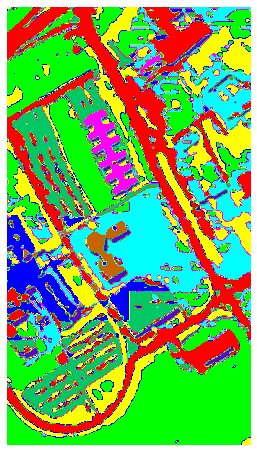

In [29]:
for eep in range(500):
    for batch_idx, (inputs, labels) in enumerate(trainloader):#batch_idx是enumerate（）函数自带的索引，从0开始
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        optimizer.zero_grad()
        #print(inputs.shape)
        #with autocast():

        output= model(inputs)

        loss=criterion(output, labels.long())
        
        optimizer.zero_grad()   # 所有参数的梯度清零
        loss.backward(retain_graph=True)         #即反向传播求梯度
        optimizer.step()        #调用optimizer进行梯度下降更新参数
        # Scales loss. 为了梯度放大.
        #scaler.scale(loss).backward()

        # scaler.step() 首先把梯度的值unscale回来.
        # 如果梯度的值不是 infs 或者 NaNs, 那么调用optimizer.step()来更新权重,
        # 否则，忽略step调用，从而保证权重不更新（不被破坏）
        #scaler.step(optimizer)

        # 准备着，看是否要增大scaler
        #scaler.update()

    if eep%10==0:
        Output=[]
        for Testbatch_idx, (Testinputs, Testtargets) in enumerate(testloader):#batch_idx是enumerate（）函数自带的索引，从0开始
            if use_cuda:
                Testinputs, Testtargets = Testinputs.cuda(), Testtargets.cuda()
            Testinputs, Testtargets = torch.autograd.Variable(Testinputs), torch.autograd.Variable(Testtargets)
            Testoutput = model(Testinputs)
            Testoutput=Testoutput.data.cpu().numpy()
            Testoutput = np.transpose(Testoutput,(0,2,3,1))
            Output.append(Testoutput[0])

        OutputWhole = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        AC, OA, AA, rightNum, testNum= ClassificationAccuracy(OutputWhole, Test_Label, class_count+1)
        kappa = Kappa(OutputWhole, Test_Label, class_count+1)
        print("eep", eep, " test", rightNum, testNum, "OA", OA, "AA", AA, "kappa", kappa)
        print(OA, AA, kappa, AC)
        #logger.info('Epoch:[{}/{}]\t test={}\{} OA={:.7f} AA={:.7f} kappa={:.7f} AC=[{}]'.format(eep , max_epoch, rightNum, testNum ,OA,AA,kappa,AC))
    if eep==260 :
        OA=np.round(OA*100, decimals=2)
        OutputWhole_show = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        Draw_Classification_Map(OutputWhole, '/home/shsun/Dingwenda/ENL-FCN/ResultImage/' + dataset_name + '_CC2B_' + str(train_ratio) + '_' + str(OA))

    if loss.data<=0.00005:
        break


#logger.info('finish training!')

model.train()
model.eval()

ImageView object:
  Interpolation       :  <default>

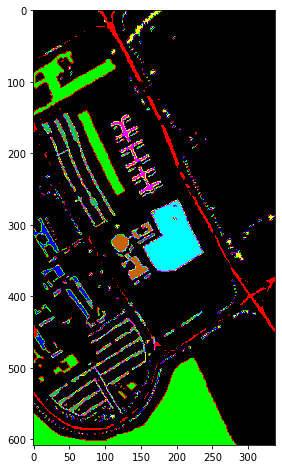

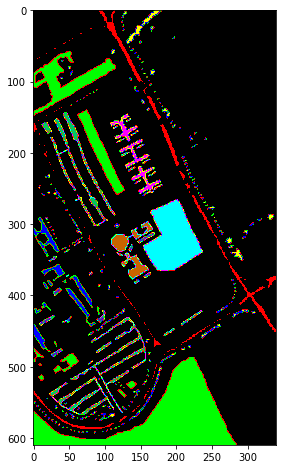

In [27]:
m, n = OutputWhole.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output_g=OutputWhole_show

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output_g[i,j] = target[i,j]
spectral.imshow(classes=output_g.astype(int),figsize=(8,8))
spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

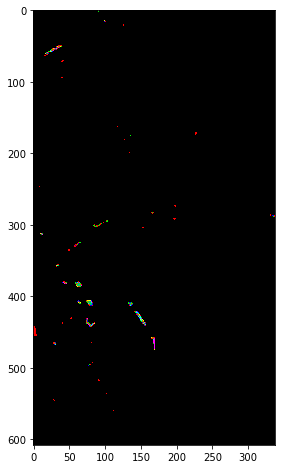

In [28]:
errors_g=output_g
for i in range(m):
    for j in range(n):
        if output_g[i,j] == gt[i,j]:
            errors_g[i,j] =0

spectral.imshow(classes=errors_g.astype(int),figsize=(8,8))

# 消融实验

In [6]:
model_ab=CCCon2B.SSCDNonLModel_ablation(class_count, n_bands, 200)
#model = CCCon2B.SSCDNonLModel_gcn6(class_count, 200, 150)
import tensorwatch as tw
import torchvision.models

# tw.model_stats(model.cuda(),[1, 200,145, 145])
print(model_ab)
if use_cuda: torch.backends.cudnn.benchmark = True
if use_cuda: model_ab.cuda()
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model_ab.parameters(), lr=learning_rate, weight_decay=2e-5)
print('lr: ',learning_rate, '  weight_dacay: ', weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4, nesterov=True)


best_acc = -1

SSCDNonLModel_ablation(
  (b1): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(103, 200, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(303, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(303, 200, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(200, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bcat): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con4): Conv2d(50, 200, kernel_size=(1, 1), stride=(1, 1))
  (s4): Sigmoid()
  (cond4): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd4): Sigmoid()
  (b5): BatchNorm2d(225, eps=1e-05, momentum=0.1, aff

In [14]:
for eep in range(600):
    for batch_idx, (inputs, labels) in enumerate(trainloader):#batch_idx是enumerate（）函数自带的索引，从0开始
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        optimizer.zero_grad()
        #print(inputs.shape)
        #with autocast():

        output= model_ab(inputs)

        loss=criterion(output, labels.long())
        
        optimizer.zero_grad()   # 所有参数的梯度清零
        loss.backward(retain_graph=True)         #即反向传播求梯度
        optimizer.step()        #调用optimizer进行梯度下降更新参数
        # Scales loss. 为了梯度放大.
        #scaler.scale(loss).backward()

        # scaler.step() 首先把梯度的值unscale回来.
        # 如果梯度的值不是 infs 或者 NaNs, 那么调用optimizer.step()来更新权重,
        # 否则，忽略step调用，从而保证权重不更新（不被破坏）
        #scaler.step(optimizer)

        # 准备着，看是否要增大scaler
        #scaler.update()

    if eep%10==0:
        Output=[]
        for Testbatch_idx, (Testinputs, Testtargets) in enumerate(testloader):#batch_idx是enumerate（）函数自带的索引，从0开始
            if use_cuda:
                Testinputs, Testtargets = Testinputs.cuda(), Testtargets.cuda()
            Testinputs, Testtargets = torch.autograd.Variable(Testinputs), torch.autograd.Variable(Testtargets)
            Testoutput = model_ab(Testinputs)
            Testoutput=Testoutput.data.cpu().numpy()
            Testoutput = np.transpose(Testoutput,(0,2,3,1))
            Output.append(Testoutput[0])

        OutputWhole_ab = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        AC, OA, AA, rightNum, testNum= ClassificationAccuracy(OutputWhole_ab, Test_Label, class_count+1)
        kappa = Kappa(OutputWhole_ab, Test_Label, class_count+1)
        print("eep", eep, " test", rightNum, testNum, "OA", OA, "AA", AA, "kappa", kappa)
        print(OA, AA, kappa, AC)
        #logger.info('Epoch:[{}/{}]\t test={}\{} OA={:.7f} AA={:.7f} kappa={:.7f} AC=[{}]'.format(eep , max_epoch, rightNum, testNum ,OA,AA,kappa,AC))
    if eep==260 :
        OA=np.round(OA*100, decimals=2)
        OutputWhole_ab_show = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        #Draw_Classification_Map(OutputWhole, '/home/shsun/Dingwenda/ENL-FCN/ResultImage/' + dataset_name + '_CC2B_' + str(train_ratio) + '_' + str(OA))

    if loss.data<=0.00005:
        break


#logger.info('finish training!')

model_ab.train()
model_ab.eval()

eep 0  test 40251 41330 OA 0.9738930558916041 AA 0.9565450511687007 kappa 0.9654953041960428
0.9738930558916041 0.9565450511687007 0.9654953041960428 [0.9771075  0.99520587 0.88694808 0.97533333 1.         0.93226526
 0.86548809 0.9969436  0.97961373]
eep 10  test 40254 41330 OA 0.9739656423905154 AA 0.9568238813102042 kappa 0.9655919683834032
0.9739656423905154 0.9568238813102042 0.9655919683834032 [0.97664346 0.99526227 0.88694808 0.97566667 1.         0.93226526
 0.867794   0.99722145 0.97961373]
eep 20  test 40258 41330 OA 0.9740624243890637 AA 0.9570168797659344 kappa 0.9657199077674058
0.9740624243890637 0.9570168797659344 0.9657199077674058 [0.97695282 0.99526227 0.88743328 0.97533333 1.         0.93246806
 0.867794   0.99722145 0.9806867 ]
eep 30  test 40260 41330 OA 0.9741108153883378 AA 0.9570510560285519 kappa 0.9657842183822449
0.9741108153883378 0.9570510560285519 0.9657842183822449 [0.97695282 0.99526227 0.88888889 0.97533333 1.         0.93267086
 0.867794   0.9969436  0

SSCDNonLModel_ablation(
  (b1): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(103, 200, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(303, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(303, 200, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(200, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bcat): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con4): Conv2d(50, 200, kernel_size=(1, 1), stride=(1, 1))
  (s4): Sigmoid()
  (cond4): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd4): Sigmoid()
  (b5): BatchNorm2d(225, eps=1e-05, momentum=0.1, aff

ImageView object:
  Interpolation       :  <default>

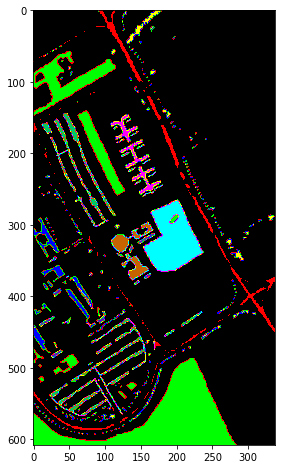

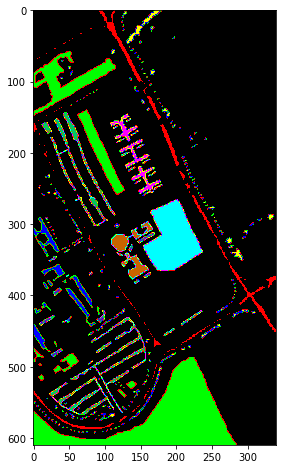

In [10]:
import spectral
m, n = OutputWhole_ab.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output_a=OutputWhole_ab_show

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output_a[i,j] = target[i,j]
spectral.imshow(classes=output_a.astype(int),figsize=(8,8))
spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

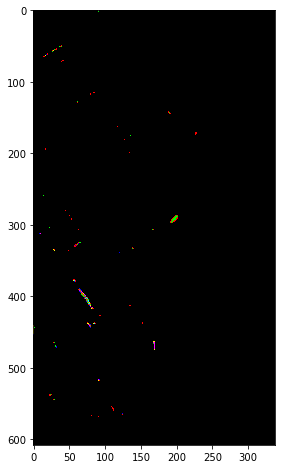

In [12]:
errors_a=output_a
for i in range(m):
    for j in range(n):
        if output_a[i,j] == gt[i,j]:
            errors_a[i,j] =0

spectral.imshow(classes=errors_a.astype(int),figsize=(8,8))

# enl-fcn


In [15]:
model_cc = CCCon2B.SSCDNonLModel(class_count, n_bands, 200)
#model = CCCon2B.SSCDNonLModel_gcn6(class_count, 200, 150)
import tensorwatch as tw
import torchvision.models

# tw.model_stats(model.cuda(),[1, 200,145, 145])
print(model_cc)
if use_cuda: torch.backends.cudnn.benchmark = True
if use_cuda: model_cc.cuda()
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model_cc.parameters(), lr=learning_rate, weight_decay=2e-5)
print('lr: ',learning_rate, '  weight_dacay: ', weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4, nesterov=True)


best_acc = -1



SSCDNonLModel(
  (b1): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(103, 200, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(303, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(303, 200, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(200, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nlcon2): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
  )
  (nlcon3): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
 

In [16]:
for eep in range(600):
    for batch_idx, (inputs, labels) in enumerate(trainloader):#batch_idx是enumerate（）函数自带的索引，从0开始
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        optimizer.zero_grad()
        #print(inputs.shape)
        #with autocast():

        output= model_cc(inputs)

        loss=criterion(output, labels.long())
        
        optimizer.zero_grad()   # 所有参数的梯度清零
        loss.backward(retain_graph=True)         #即反向传播求梯度
        optimizer.step()        #调用optimizer进行梯度下降更新参数
        # Scales loss. 为了梯度放大.
        #scaler.scale(loss).backward()

        # scaler.step() 首先把梯度的值unscale回来.
        # 如果梯度的值不是 infs 或者 NaNs, 那么调用optimizer.step()来更新权重,
        # 否则，忽略step调用，从而保证权重不更新（不被破坏）
        #scaler.step(optimizer)

        # 准备着，看是否要增大scaler
        #scaler.update()

    if eep%10==0:
        Output=[]
        for Testbatch_idx, (Testinputs, Testtargets) in enumerate(testloader):#batch_idx是enumerate（）函数自带的索引，从0开始
            if use_cuda:
                Testinputs, Testtargets = Testinputs.cuda(), Testtargets.cuda()

                
            Testinputs, Testtargets = torch.autograd.Variable(Testinputs), torch.autograd.Variable(Testtargets)
            Testoutput = model_cc(Testinputs)
            Testoutput=Testoutput.data.cpu().numpy()
            Testoutput = np.transpose(Testoutput,(0,2,3,1))
            Output.append(Testoutput[0])

        OutputWhole_cc = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        AC, OA, AA, rightNum, testNum= ClassificationAccuracy(OutputWhole_cc, Test_Label, class_count+1)
        kappa = Kappa(OutputWhole_cc, Test_Label, class_count+1)
        print("eep", eep, " test", rightNum, testNum, "OA", OA, "AA", AA, "kappa", kappa)
        print(OA, AA, kappa, AC)
        #logger.info('Epoch:[{}/{}]\t test={}\{} OA={:.7f} AA={:.7f} kappa={:.7f} AC=[{}]'.format(eep , max_epoch, rightNum, testNum ,OA,AA,kappa,AC))
    if eep==560 :
        OA=np.round(OA*100, decimals=2)
        OutputWhole_cc_show = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        #Draw_Classification_Map(OutputWhole, '/home/shsun/Dingwenda/ENL-FCN/ResultImage/' + dataset_name + '_CC2B_' + str(train_ratio) + '_' + str(OA))

    if loss.data<=0.00005:
        break


#logger.info('finish training!')

model_cc.train()
model_cc.eval()

eep 0  test 6465 41330 OA 0.15642390515364143 AA 0.1111111111111111 kappa 0.0
0.15642390515364143 0.1111111111111111 0.0 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
eep 10  test 23422 41330 OA 0.5667069924993952 AA 0.21159962801605872 kappa 0.3250880146568291
0.5667069924993952 0.21159962801605872 0.3250880146568291 [0.80340294 1.         0.         0.         0.         0.10099371
 0.         0.         0.        ]
eep 20  test 26552 41330 OA 0.6424389063634164 AA 0.2756109519759726 kappa 0.48323724161955783
0.6424389063634164 0.2756109519759726 0.48323724161955783 [0.99195669 1.         0.         0.         0.         0.48854188
 0.         0.         0.        ]
eep 30  test 30053 41330 OA 0.7271473505927898 AA 0.390525581762521 kappa 0.623572085883756
0.7271473505927898 0.390525581762521 0.623572085883756 [0.99597834 0.98539199 0.         0.73433333 0.         0.79902657
 0.         0.         0.        ]
eep 40  test 32508 41330 OA 0.7865473022017905 AA 0.45899957708085726 kappa 0.7087978777360

SSCDNonLModel(
  (b1): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(103, 200, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(303, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(303, 200, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(200, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nlcon2): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
  )
  (nlcon3): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
 

ImageView object:
  Interpolation       :  <default>

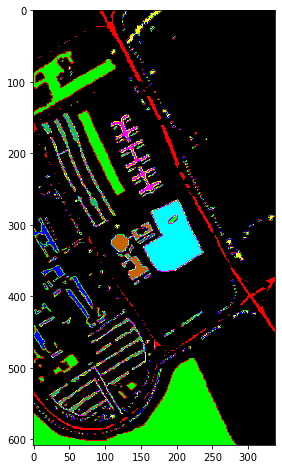

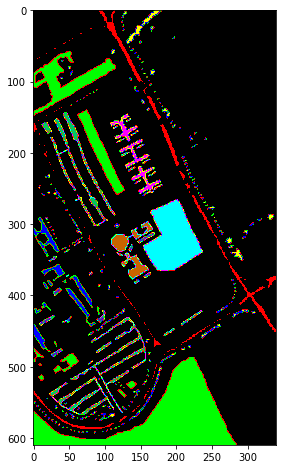

In [17]:
import spectral
m, n = OutputWhole_cc.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output_c=OutputWhole_cc_show

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output_c[i,j] = target[i,j]
spectral.imshow(classes=output_c.astype(int),figsize=(8,8))
spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

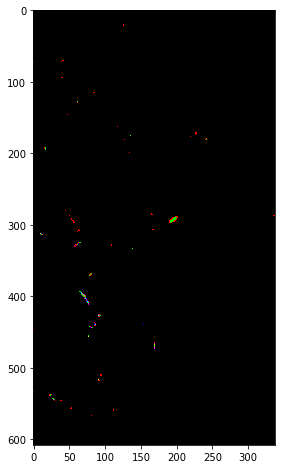

In [18]:
errors_c=output_c
for i in range(m):
    for j in range(n):
        if output_c[i,j] == gt[i,j]:
            errors_c[i,j] =0

spectral.imshow(classes=errors_c.astype(int),figsize=(8,8))